In [1]:
import logging
import sys


date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

# Data

### Training data
- Source: http://mattmahoney.net/dc/text8.zip
- Stored in: `data/train.txt`

### Analogies data
- Source: https://raw.githubusercontent.com/nicholas-leonard/word2vec/refs/heads/master/questions-words.txt
- Stored in: `data/analogies.txt`

# Defining model

In [2]:
from scipy.spatial import distance

def evaluate_analogy(model, word_tuple):
    w0_embedding = model.wv[word_tuple[0]]
    w1_embedding = model.wv[word_tuple[1]]
    w2_embedding = model.wv[word_tuple[2]]
    w3_embedding = model.wv[word_tuple[3]]

    return 1 - distance.cosine(
        w1_embedding - w0_embedding,
        w3_embedding - w2_embedding,
    )


In [3]:
analogies_file_name = "../data/analogies.txt"

with open(analogies_file_name) as file:
    file_content = file.read().splitlines()

analogies = {}
last_key_added = None
for line in file_content:
    if line[0] == ":":
        last_key_added = line.replace(": ", "")
        analogies[last_key_added] = []

    else:
        analogies[last_key_added].append(
            line.lower().split(" ")
        )

analogies[last_key_added][:3]

[['decrease', 'decreases', 'describe', 'describes'],
 ['decrease', 'decreases', 'eat', 'eats'],
 ['decrease', 'decreases', 'enhance', 'enhances']]

In [4]:
from gensim.models import Word2Vec


word_embedder = Word2Vec(
    sg=0,
    window=15,
    vector_size=100,
    min_count=0,
    workers=8,
)

word_embedder.build_vocab(corpus_file="../data/train.txt")


2024-12-24 14:15:41 Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2024-12-01T14:15:41.006456', 'gensim': '4.3.3', 'python': '3.10.14 (main, Apr 15 2024, 18:28:39) [Clang 17.0.6 ]', 'platform': 'Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'created'}
2024-12-24 14:15:41 collecting all words and their counts
2024-12-24 14:15:42 PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-12-24 14:15:46 collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2024-12-24 14:15:46 Creating a fresh vocabulary
2024-12-24 14:15:47 Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 253854 unique words (100.00% of original 253854, drops 0)', 'datetime': '2024-12-01T14:15:47.406506', 'gensim': '4.3.3', 'python': '3.10.14 (main, Apr 15 2024, 18:28:39) [Clang 17.0.6 ]', 'platform': 'Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_voca

In [5]:
import numpy as np

pre_train_report = {k: 0.0 for k in analogies.keys()}
for sub_category in pre_train_report.keys():
    pre_train_report[sub_category] = np.average(
        [
            evaluate_analogy(word_embedder, curr_sample) for curr_sample in analogies[sub_category]
            if all([word_embedder.wv.__contains__(sample) for sample in curr_sample])
        ]
    )

pre_train_report["overall_average"] = np.average(list(pre_train_report.values()))
pre_train_report

{'capital-common-countries': -0.0190753050667281,
 'capital-world': 0.00011781289564310657,
 'currency': 0.005994183456904846,
 'city-in-state': 0.008210786652111338,
 'family': 0.010170468707909807,
 'gram1-adjective-to-adverb': 0.003967221573922239,
 'gram2-opposite': 0.002679524996556664,
 'gram3-comparative': 0.005164259228856728,
 'gram4-superlative': 0.012297384400440736,
 'gram5-present-participle': -0.0021538758231991898,
 'gram6-nationality-adjective': -0.0032214598792646063,
 'gram7-past-tense': 0.0063834959049128516,
 'gram8-plural': -0.0025468158506207587,
 'gram9-plural-verbs': -0.0028589959133531843,
 'overall_average': 0.0017949060917208917}

In [6]:
from gensim.models.callbacks import CallbackAny2Vec


loss_curve = []

class EpochLogger(CallbackAny2Vec):
    def __init__(self, losses_array):
        self.epoch = 0
        self.last_logged_loss = 0
        self.losses_array = losses_array

    def on_epoch_begin(self, model):
        print(f"Epoch #{self.epoch} start")

    def on_epoch_end(self, model):
        curr_loss = model.get_latest_training_loss() - self.last_logged_loss
        self.last_logged_loss = model.get_latest_training_loss()

        self.losses_array.append(curr_loss)

        print(
            f"Epoch #{self.epoch} end.\nTraining loss: {curr_loss}"
        )
        self.epoch += 1

word_embedder.train(
    corpus_file="../data/train.txt",
    total_words=17005207,
    epochs=50,
    compute_loss=True,
    callbacks=[EpochLogger(loss_curve)]
)

2024-12-24 14:15:51 Word2Vec lifecycle event {'msg': 'training model with 8 workers on 253854 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=15 shrink_windows=True', 'datetime': '2024-12-01T14:15:51.532713', 'gensim': '4.3.3', 'python': '3.10.14 (main, Apr 15 2024, 18:28:39) [Clang 17.0.6 ]', 'platform': 'Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'train'}
Epoch #0 start
2024-12-24 14:15:58 EPOCH 0 - PROGRESS: at 0.12% words, 1470 words/s, in_qsize -1, out_qsize 1
2024-12-24 14:16:05 EPOCH 0 - PROGRESS: at 0.24% words, 1521 words/s, in_qsize -1, out_qsize 1
2024-12-24 14:16:10 EPOCH 0 - PROGRESS: at 0.35% words, 1648 words/s, in_qsize -1, out_qsize 1
2024-12-24 14:16:13 EPOCH 0 - PROGRESS: at 0.47% words, 1815 words/s, in_qsize -1, out_qsize 1
2024-12-24 14:16:16 EPOCH 0 - PROGRESS: at 0.59% words, 1996 words/s, in_qsize -1, out_qsize 1
2024-12-24 14:16:18 EPOCH 0 - PROGRESS: at 0.71% words, 2249 words/s, in_qsize -1, out_qsiz

(4000000, 8000000)

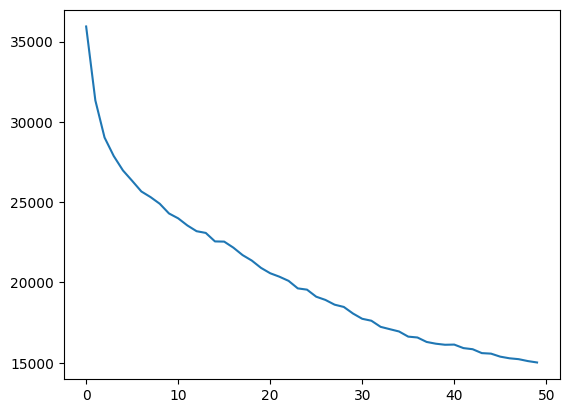

In [7]:
import matplotlib.pyplot as plt

plt.plot(loss_curve)
plt.show()

In [8]:
trained_model_report = {k: 0.0 for k in analogies.keys()}
for sub_category in trained_model_report.keys():
    trained_model_report[sub_category] = np.average(
        [
            evaluate_analogy(word_embedder, curr_sample) for curr_sample in analogies[sub_category]
            if all([word_embedder.wv.__contains__(sample) for sample in curr_sample])
        ]
    )

trained_model_report["overall_average"] = np.average(list(trained_model_report.values()))
trained_model_report

{'capital-common-countries': 0.48117078409970776,
 'capital-world': 0.11512080931978953,
 'currency': 0.32619069926864996,
 'city-in-state': 0.18606172965728632,
 'family': 0.022491989700331335,
 'gram1-adjective-to-adverb': 0.013529625392852589,
 'gram2-opposite': 0.03379999310938696,
 'gram3-comparative': 0.1468444488509413,
 'gram4-superlative': 0.2804227630841504,
 'gram5-present-participle': 0.06836351010010285,
 'gram6-nationality-adjective': 0.14317885815158327,
 'gram7-past-tense': 0.044691838761660635,
 'gram8-plural': 0.006598624883797181,
 'gram9-plural-verbs': 0.11750675196554294,
 'overall_average': 0.14185517331041306}